In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 3)
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

def do_arima(series):
    X = list(series.values)
    size = int(len(X) * 0.65)
    train, test = X[0:size], X[size:]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(train, order=(3,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        train.append(obs)

    rmse = sqrt(mean_squared_error(test, predictions))
    print(series.name.upper(), '   Test RMSE: %.3f' % rmse)

    plt.plot(test, label = 'real')
    plt.plot(predictions, color='red', label = 'pred')
    plt.legend(loc = 'upper right')
    plt.show()
    

ARIMA(p, d, q), our case: ARIMA(2, 1, 0) <br>
p: The number of lag observations included in the model, also called the lag order. <br>
d: The number of times that the raw observations are differenced, also called the degree of differencing. <br>
q: The size of the moving average window, also called the order of moving average. <br>

In [2]:
df = pd.read_csv("data/all_prices.csv", parse_dates = True)

XRP    Test RMSE: 0.043


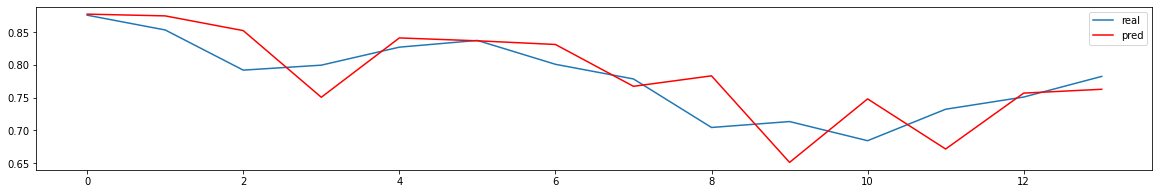

BTC    Test RMSE: 1565.654


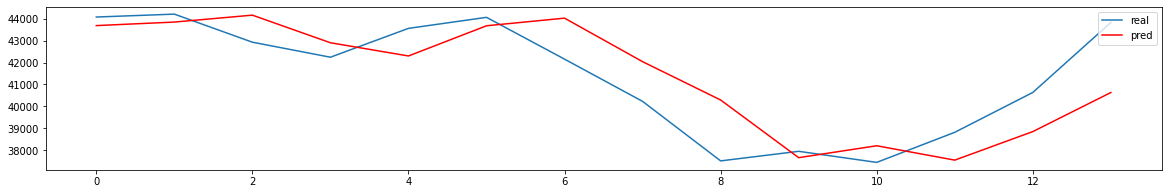

GOLD    Test RMSE: 15.564


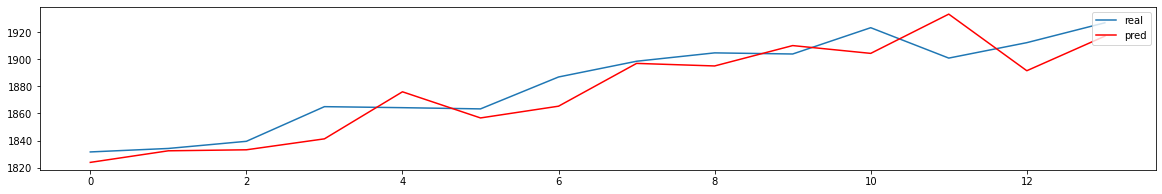

SNP    Test RMSE: 61.230


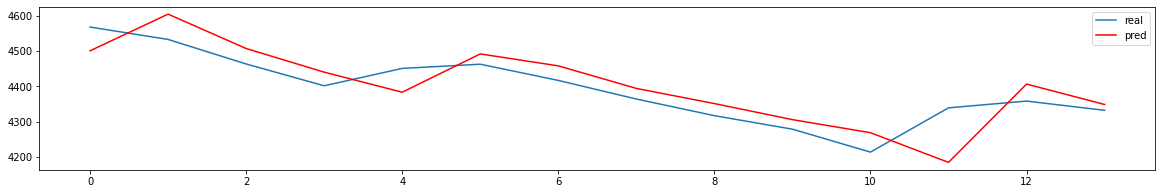

VIX    Test RMSE: 3.013


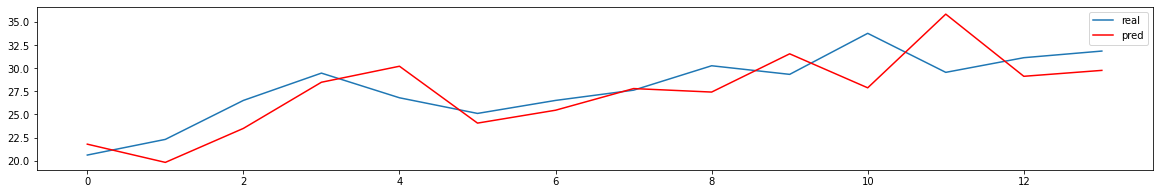

In [3]:
do_arima(df.xrp)
do_arima(df.btc)
do_arima(df.gold)
do_arima(df.snp)
do_arima(df.vix)

In [4]:
tonormdf = df.iloc[:, 1:]
minmaxnorm_df = (tonormdf - tonormdf.min()) / (tonormdf.max() - tonormdf.min())
minmaxnorm_df.describe()

,xrp,XRP_volume_usdt,tradecount,btc,gold,snp,vix
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.483702,0.295639,0.283691,0.475847,0.349861,0.495697,0.474466
std,0.305072,0.188318,0.175760,0.273074,0.293675,0.256070,0.284322
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222784,0.171432,0.168481,0.192190,0.120816,0.269515,0.216743
50%,0.554341,0.249674,0.228805,0.565833,0.259571,0.481310,0.420288
75%,0.674687,0.358018,0.360036,0.686156,0.531163,0.684205,0.745662
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


XRP    Test RMSE: 0.158


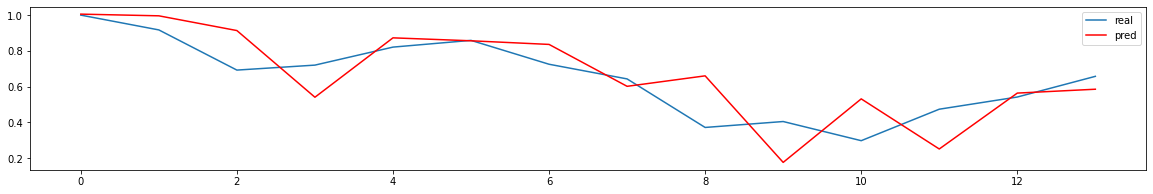

/Users/mgaulia/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


BTC    Test RMSE: 0.152


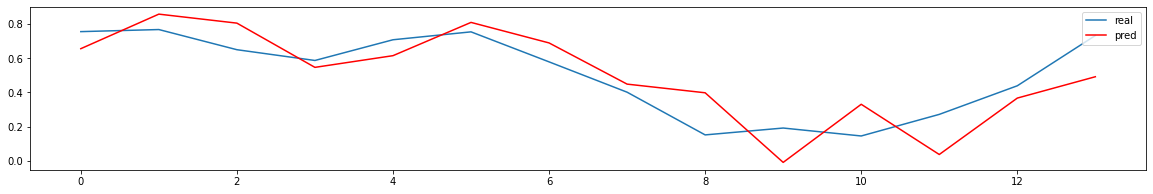

GOLD    Test RMSE: 0.115


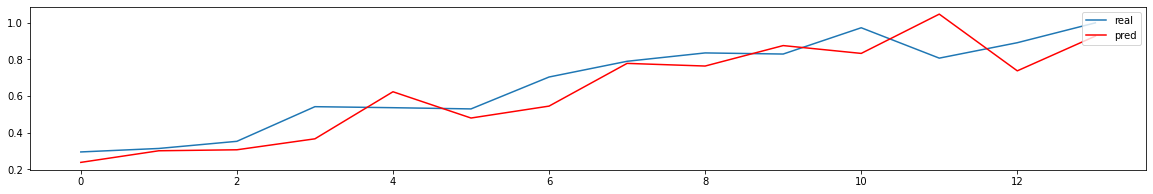

/Users/mgaulia/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgaulia/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mgaulia/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SNP    Test RMSE: 0.105


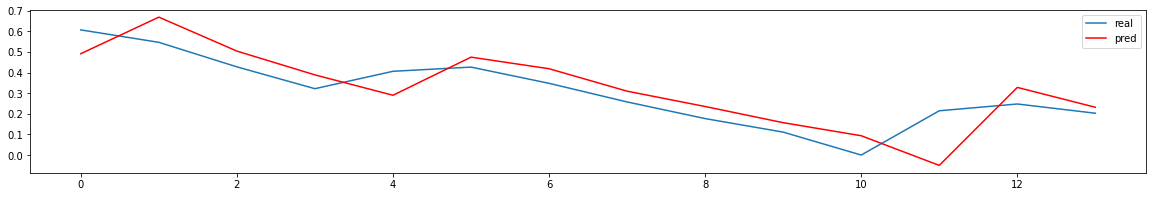

VIX    Test RMSE: 0.179


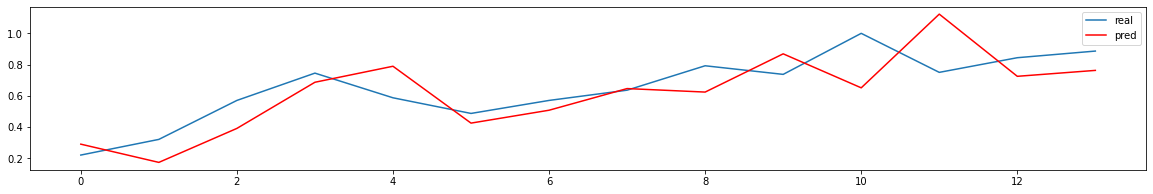

In [5]:
do_arima(minmaxnorm_df.xrp)
do_arima(minmaxnorm_df.btc)
do_arima(minmaxnorm_df.gold)
do_arima(minmaxnorm_df.snp)
do_arima(minmaxnorm_df.vix)

In [6]:
meansdnrm_df = (tonormdf - tonormdf.mean()) / tonormdf.std(ddof = 1)
meansdnrm_df.describe()

,xrp,XRP_volume_usdt,tradecount,btc,gold,snp,vix
count,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
mean,-6.439294e-16,-6.661338e-17,8.881784e-17,1.176836e-15,-8.293366e-15,-4.440892e-16,5.551115e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.585532e+00,-1.569889e+00,-1.614084e+00,-1.742560e+00,-1.191322e+00,-1.935791e+00,-1.668766e+00
25%,-8.552672e-01,-6.595559e-01,-6.554977e-01,-1.038756e+00,-7.799292e-01,-8.832857e-01,-9.064483e-01
50%,2.315468e-01,-2.440789e-01,-3.122776e-01,3.295288e-01,-3.074500e-01,-5.618483e-02,-1.905533e-01
75%,6.260294e-01,3.312416e-01,4.343701e-01,7.701552e-01,6.173561e-01,7.361559e-01,9.538356e-01
max,1.692377e+00,3.740271e+00,4.075499e+00,1.919455e+00,2.213804e+00,1.969396e+00,1.848378e+00


XRP    Test RMSE: 0.517


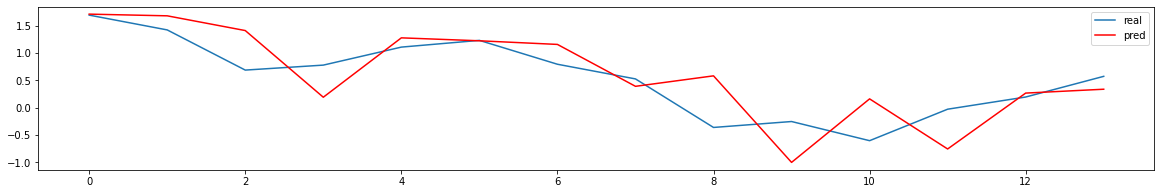

BTC    Test RMSE: 0.556


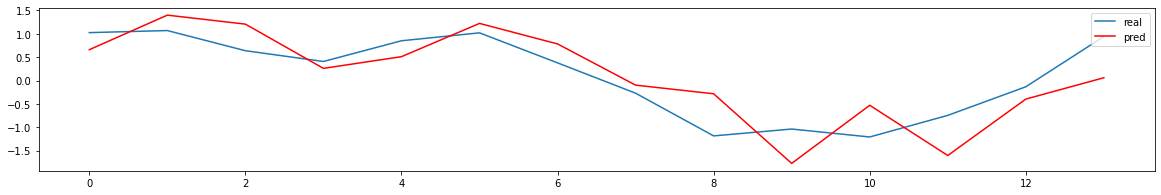

GOLD    Test RMSE: 0.392


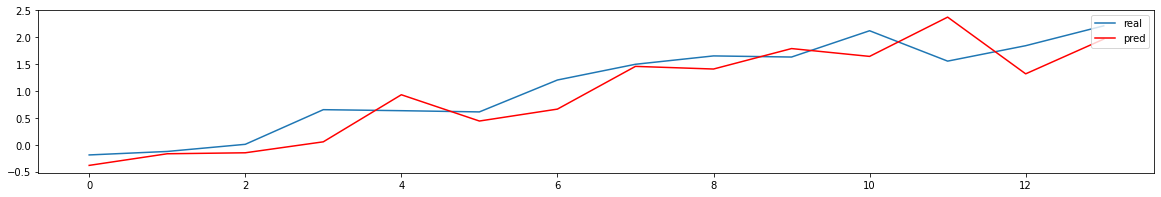

SNP    Test RMSE: 0.409


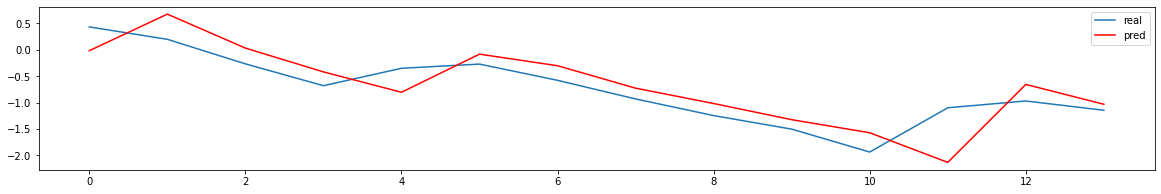

VIX    Test RMSE: 0.629


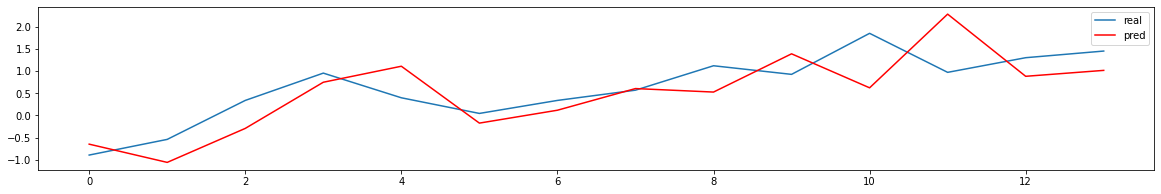

In [7]:
do_arima(meansdnrm_df.xrp)
do_arima(meansdnrm_df.btc)
do_arima(meansdnrm_df.gold)
do_arima(meansdnrm_df.snp)
do_arima(meansdnrm_df.vix)